In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(337576, 828)
(337576, 1)
validation
(56520, 828)
(56520, 1)
test
(26800, 828)
(26800, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/34 [..............................] - ETA: 53s - loss: 0.0158 - STD: 1.1610e-04 - MAE: 0.0919

 4/34 [==>...........................] - ETA: 0s - loss: 0.0203 - STD: 5.7028e-04 - MAE: 0.1013 

 5/34 [===>..........................] - ETA: 1s - loss: 0.0203 - STD: 8.1025e-04 - MAE: 0.1056

 6/34 [====>.........................] - ETA: 1s - loss: 0.0194 - STD: 9.9981e-04 - MAE: 0.1031

 7/34 [=====>........................] - ETA: 1s - loss: 0.0191 - STD: 0.0012 - MAE: 0.0989    

 8/34 [======>.......................] - ETA: 1s - loss: 0.0189 - STD: 0.0013 - MAE: 0.0959

 9/34 [======>.......................] - ETA: 1s - loss: 0.0188 - STD: 0.0014 - MAE: 0.0935

10/34 [=======>......................] - ETA: 1s - loss: 0.0186 - STD: 0.0016 - MAE: 0.0913

11/34 [========>.....................] - ETA: 1s - loss: 0.0182 - STD: 0.0018 - MAE: 0.0898

12/34 [=========>....................] - ETA: 1s - loss: 0.0179 - STD: 0.0020 - MAE: 0.0898

13/34 [==========>...................] - ETA: 1s - loss: 0.0177 - STD: 0.0022 - MAE: 0.0906

14/34 [===========>..................] - ETA: 1s - loss: 0.0176 - STD: 0.0024 - MAE: 0.0912

15/34 [============>.................] - ETA: 1s - loss: 0.0174 - STD: 0.0027 - MAE: 0.0910

16/34 [=============>................] - ETA: 1s - loss: 0.0172 - STD: 0.0029 - MAE: 0.0903

17/34 [==============>...............] - ETA: 1s - loss: 0.0171 - STD: 0.0031 - MAE: 0.0892

18/34 [==============>...............] - ETA: 1s - loss: 0.0169 - STD: 0.0034 - MAE: 0.0881

19/34 [===============>..............] - ETA: 1s - loss: 0.0168 - STD: 0.0036 - MAE: 0.0872

20/34 [================>.............] - ETA: 1s - loss: 0.0167 - STD: 0.0039 - MAE: 0.0863

21/34 [=================>............] - ETA: 0s - loss: 0.0166 - STD: 0.0043 - MAE: 0.0857

22/34 [==================>...........] - ETA: 0s - loss: 0.0164 - STD: 0.0047 - MAE: 0.0855

23/34 [===================>..........] - ETA: 0s - loss: 0.0163 - STD: 0.0052 - MAE: 0.0854

24/34 [====================>.........] - ETA: 0s - loss: 0.0161 - STD: 0.0057 - MAE: 0.0853

25/34 [=====================>........] - ETA: 0s - loss: 0.0160 - STD: 0.0063 - MAE: 0.0851

28/34 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 0.0084 - MAE: 0.0831

30/34 [=========================>....] - ETA: 0s - loss: 0.0152 - STD: 0.0103 - MAE: 0.0816

31/34 [==========================>...] - ETA: 0s - loss: 0.0150 - STD: 0.0116 - MAE: 0.0810

32/34 [===========================>..] - ETA: 0s - loss: 0.0148 - STD: 0.0130 - MAE: 0.0805

33/34 [============================>.] - ETA: 0s - loss: 0.0146 - STD: 0.0145 - MAE: 0.0799

34/34 [==============================] - ETA: 0s - loss: 0.0144 - STD: 0.0162 - MAE: 0.0793

34/34 [==============================] - 6s 120ms/step - loss: 0.0144 - STD: 0.0162 - MAE: 0.0793 - val_loss: 0.0070 - val_STD: 0.0728 - val_MAE: 0.0554


Epoch 2/10000


 1/34 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0786 - MAE: 0.0542

 2/34 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0813 - MAE: 0.0537

 3/34 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0849 - MAE: 0.0540

 4/34 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0881 - MAE: 0.0538

 5/34 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0920 - MAE: 0.0536

 6/34 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0952 - MAE: 0.0532

 7/34 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0972 - MAE: 0.0526

 8/34 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0984 - MAE: 0.0520

 9/34 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0987 - MAE: 0.0513

10/34 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0987 - MAE: 0.0506

11/34 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0987 - MAE: 0.0501

12/34 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0988 - MAE: 0.0498

13/34 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0986 - MAE: 0.0495

14/34 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0983 - MAE: 0.0492

15/34 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0983 - MAE: 0.0489

16/34 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0985 - MAE: 0.0486

17/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0991 - MAE: 0.0482

18/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.1002 - MAE: 0.0480

19/34 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.1010 - MAE: 0.0478

20/34 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.1016 - MAE: 0.0476

21/34 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.1020 - MAE: 0.0475

22/34 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.1024 - MAE: 0.0473

23/34 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.1028 - MAE: 0.0471

24/34 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.1029 - MAE: 0.0470

25/34 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.1030 - MAE: 0.0468

26/34 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.1030 - MAE: 0.0467

27/34 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.1028 - MAE: 0.0466

28/34 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.1028 - MAE: 0.0465

29/34 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.1029 - MAE: 0.0464

30/34 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.1031 - MAE: 0.0463

31/34 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.1034 - MAE: 0.0462

32/34 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.1036 - MAE: 0.0460

33/34 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.1038 - MAE: 0.0460

34/34 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.1039 - MAE: 0.0459

34/34 [==============================] - 3s 84ms/step - loss: 0.0045 - STD: 0.1039 - MAE: 0.0459 - val_loss: 0.0045 - val_STD: 0.0961 - val_MAE: 0.0436


Epoch 3/10000


 1/34 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.1102 - MAE: 0.0433

 2/34 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.1091 - MAE: 0.0430

 3/34 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.1082 - MAE: 0.0433

 4/34 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.1075 - MAE: 0.0432

 5/34 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.1069 - MAE: 0.0430

 6/34 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.1062 - MAE: 0.0430

 7/34 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.1059 - MAE: 0.0430

 8/34 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.1059 - MAE: 0.0430

 9/34 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.1062 - MAE: 0.0431

10/34 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.1060 - MAE: 0.0431

11/34 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.1063 - MAE: 0.0431

12/34 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.1064 - MAE: 0.0431

13/34 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.1064 - MAE: 0.0431

14/34 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.1064 - MAE: 0.0431

15/34 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.1064 - MAE: 0.0431

16/34 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.1061 - MAE: 0.0431

17/34 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.1062 - MAE: 0.0431

18/34 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.1063 - MAE: 0.0431

19/34 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.1062 - MAE: 0.0431

20/34 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.1061 - MAE: 0.0430

21/34 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.1061 - MAE: 0.0430

22/34 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.1063 - MAE: 0.0430

23/34 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.1064 - MAE: 0.0430

24/34 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.1062 - MAE: 0.0430

25/34 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.1063 - MAE: 0.0430

26/34 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.1063 - MAE: 0.0430

27/34 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.1065 - MAE: 0.0430

28/34 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.1065 - MAE: 0.0429

29/34 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.1065 - MAE: 0.0429

30/34 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.1065 - MAE: 0.0429

31/34 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.1067 - MAE: 0.0429

32/34 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.1067 - MAE: 0.0429

33/34 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.1068 - MAE: 0.0429

34/34 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.1069 - MAE: 0.0429

34/34 [==============================] - 3s 83ms/step - loss: 0.0039 - STD: 0.1069 - MAE: 0.0429 - val_loss: 0.0044 - val_STD: 0.0970 - val_MAE: 0.0435


Epoch 4/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.1066 - MAE: 0.0423

 2/34 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.1059 - MAE: 0.0419

 3/34 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.1065 - MAE: 0.0422

 4/34 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.1075 - MAE: 0.0422

 5/34 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0421

 6/34 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0422

 7/34 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.1079 - MAE: 0.0423

 8/34 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.1079 - MAE: 0.0423

 9/34 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.1080 - MAE: 0.0423

10/34 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.1076 - MAE: 0.0423

11/34 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0423

12/34 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.1078 - MAE: 0.0423

13/34 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.1081 - MAE: 0.0423

14/34 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.1082 - MAE: 0.0423

15/34 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.1081 - MAE: 0.0423

16/34 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.1081 - MAE: 0.0423

17/34 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.1081 - MAE: 0.0423

18/34 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.1082 - MAE: 0.0423

19/34 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.1078 - MAE: 0.0422

20/34 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.1075 - MAE: 0.0422

21/34 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.1076 - MAE: 0.0422

22/34 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.1076 - MAE: 0.0422

23/34 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.1076 - MAE: 0.0422

24/34 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.1075 - MAE: 0.0422

25/34 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.1076 - MAE: 0.0421

26/34 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0421

27/34 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0421

28/34 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.1076 - MAE: 0.0421

29/34 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0421

30/34 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.1079 - MAE: 0.0421

31/34 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.1078 - MAE: 0.0421

32/34 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0421

33/34 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0421

34/34 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.1078 - MAE: 0.0421

34/34 [==============================] - 3s 84ms/step - loss: 0.0038 - STD: 0.1078 - MAE: 0.0421 - val_loss: 0.0042 - val_STD: 0.0999 - val_MAE: 0.0430


Epoch 5/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.1096 - MAE: 0.0410

 2/34 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.1089 - MAE: 0.0414

 3/34 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.1094 - MAE: 0.0416

 4/34 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.1109 - MAE: 0.0420

 5/34 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.1101 - MAE: 0.0420

 6/34 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.1090 - MAE: 0.0419

 7/34 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.1088 - MAE: 0.0418

 8/34 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.1089 - MAE: 0.0420

 9/34 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.1083 - MAE: 0.0420

10/34 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.1082 - MAE: 0.0419

11/34 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.1087 - MAE: 0.0419

12/34 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.1089 - MAE: 0.0419

13/34 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.1086 - MAE: 0.0419

14/34 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.1088 - MAE: 0.0419

15/34 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.1091 - MAE: 0.0418

16/34 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.1093 - MAE: 0.0419

17/34 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.1089 - MAE: 0.0418

18/34 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.1089 - MAE: 0.0419

19/34 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.1090 - MAE: 0.0419

20/34 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.1088 - MAE: 0.0418

21/34 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.1086 - MAE: 0.0418

22/34 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.1086 - MAE: 0.0418

23/34 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.1088 - MAE: 0.0418

24/34 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.1088 - MAE: 0.0418

25/34 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.1087 - MAE: 0.0418

26/34 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.1087 - MAE: 0.0417

27/34 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.1088 - MAE: 0.0418

28/34 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.1085 - MAE: 0.0417

29/34 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.1085 - MAE: 0.0417

30/34 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.1085 - MAE: 0.0417

31/34 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.1085 - MAE: 0.0417

32/34 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.1084 - MAE: 0.0417

33/34 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.1084 - MAE: 0.0416

34/34 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.1085 - MAE: 0.0416

34/34 [==============================] - 3s 81ms/step - loss: 0.0036 - STD: 0.1085 - MAE: 0.0416 - val_loss: 0.0041 - val_STD: 0.0988 - val_MAE: 0.0423


Epoch 6/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.1079 - MAE: 0.0411

 2/34 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.1085 - MAE: 0.0410

 3/34 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.1084 - MAE: 0.0409

 4/34 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.1084 - MAE: 0.0410

 5/34 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.1084 - MAE: 0.0409

 6/34 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.1081 - MAE: 0.0408

 7/34 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.1085 - MAE: 0.0409

 8/34 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.1087 - MAE: 0.0409

 9/34 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.1084 - MAE: 0.0408

10/34 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.1084 - MAE: 0.0407

11/34 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0407

12/34 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.1087 - MAE: 0.0408

13/34 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0408

14/34 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.1092 - MAE: 0.0408

15/34 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.1092 - MAE: 0.0409

16/34 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.1092 - MAE: 0.0408

17/34 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1093 - MAE: 0.0409

18/34 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1091 - MAE: 0.0408

19/34 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0408

20/34 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.1091 - MAE: 0.0408

21/34 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.1089 - MAE: 0.0408

22/34 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.1089 - MAE: 0.0408

23/34 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.1090 - MAE: 0.0408

25/34 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.1091 - MAE: 0.0408

26/34 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.1092 - MAE: 0.0408

27/34 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.1091 - MAE: 0.0408

28/34 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1090 - MAE: 0.0408

29/34 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1090 - MAE: 0.0408

30/34 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1089 - MAE: 0.0408

32/34 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1091 - MAE: 0.0408

33/34 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1090 - MAE: 0.0408

34/34 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1091 - MAE: 0.0408

34/34 [==============================] - 3s 79ms/step - loss: 0.0035 - STD: 0.1091 - MAE: 0.0408 - val_loss: 0.0039 - val_STD: 0.1021 - val_MAE: 0.0419


Epoch 7/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.1121 - MAE: 0.0408

 2/34 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0404

 3/34 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1099 - MAE: 0.0404

 4/34 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.1101 - MAE: 0.0406

 5/34 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0404

 6/34 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.1093 - MAE: 0.0402

 7/34 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0403

 8/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0403

 9/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0403

10/34 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0402

11/34 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0403

12/34 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.1093 - MAE: 0.0402

13/34 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0402

14/34 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.1093 - MAE: 0.0403

16/34 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0403

17/34 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.1100 - MAE: 0.0403

18/34 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.1101 - MAE: 0.0403

19/34 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.1101 - MAE: 0.0403

20/34 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0403

21/34 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0402

22/34 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0402

23/34 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0401

24/34 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0401

25/34 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0401

26/34 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0401

27/34 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0401

28/34 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0401

29/34 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0402

30/34 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0403

31/34 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0403

32/34 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0403

33/34 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0404

34/34 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0405

34/34 [==============================] - 2s 65ms/step - loss: 0.0034 - STD: 0.1096 - MAE: 0.0405 - val_loss: 0.0039 - val_STD: 0.1047 - val_MAE: 0.0431


Epoch 8/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.1192 - MAE: 0.0428

 2/34 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.1144 - MAE: 0.0414

 3/34 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.1107 - MAE: 0.0410

 5/34 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.1104 - MAE: 0.0405

 6/34 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.1101 - MAE: 0.0403

 7/34 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.1104 - MAE: 0.0403

 8/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1099 - MAE: 0.0401

 9/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0399

10/34 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0399

11/34 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0399

12/34 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.1100 - MAE: 0.0398

13/34 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0398

14/34 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0398

15/34 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1104 - MAE: 0.0398

16/34 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1104 - MAE: 0.0397

17/34 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0397

18/34 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0398

19/34 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1100 - MAE: 0.0398

20/34 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1100 - MAE: 0.0397

21/34 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0398

22/34 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0397

23/34 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0397

24/34 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1104 - MAE: 0.0397

25/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0397

26/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0397

27/34 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0397

28/34 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0396

29/34 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0396

30/34 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0396

31/34 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0396

32/34 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0396

33/34 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0396

34/34 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0396

34/34 [==============================] - 2s 64ms/step - loss: 0.0033 - STD: 0.1102 - MAE: 0.0396 - val_loss: 0.0043 - val_STD: 0.0938 - val_MAE: 0.0433


Epoch 9/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0405

 2/34 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.1074 - MAE: 0.0410

 3/34 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1066 - MAE: 0.0408

 4/34 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.1079 - MAE: 0.0404

 5/34 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.1085 - MAE: 0.0402

 6/34 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1090 - MAE: 0.0401

 7/34 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1093 - MAE: 0.0400

 8/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0398

 9/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0398

10/34 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0398

11/34 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0397

12/34 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0396

13/34 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.1099 - MAE: 0.0395

15/34 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0396

16/34 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1100 - MAE: 0.0396

17/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0396

18/34 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0396

19/34 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0397

20/34 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0397

21/34 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0397

22/34 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0397

23/34 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0397

24/34 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0398

25/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0398

26/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0398

27/34 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0398

28/34 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0398

29/34 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0399

30/34 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0398

31/34 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0398

32/34 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0399

33/34 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0399

34/34 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0398

34/34 [==============================] - 2s 64ms/step - loss: 0.0033 - STD: 0.1103 - MAE: 0.0398 - val_loss: 0.0039 - val_STD: 0.0959 - val_MAE: 0.0411


Epoch 10/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.1049 - MAE: 0.0391

 2/34 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0397

 3/34 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0393

 4/34 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0392

 5/34 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.1102 - MAE: 0.0391

 6/34 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0392

 7/34 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.1100 - MAE: 0.0391

 8/34 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1107 - MAE: 0.0391

 9/34 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1102 - MAE: 0.0393

10/34 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0392

11/34 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.1105 - MAE: 0.0392

12/34 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.1099 - MAE: 0.0392

13/34 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.1099 - MAE: 0.0393

14/34 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.1098 - MAE: 0.0392

15/34 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.1099 - MAE: 0.0392

16/34 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1102 - MAE: 0.0392

17/34 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0391

18/34 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0391

19/34 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0391

20/34 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.1102 - MAE: 0.0391

21/34 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0390

22/34 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0390

23/34 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0390

24/34 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0389

25/34 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0389

26/34 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0389

27/34 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0389

29/34 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0388

30/34 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0389

31/34 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1102 - MAE: 0.0389

32/34 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0388

33/34 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0389

34/34 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0388

34/34 [==============================] - 2s 65ms/step - loss: 0.0032 - STD: 0.1104 - MAE: 0.0388 - val_loss: 0.0037 - val_STD: 0.0999 - val_MAE: 0.0403


Epoch 11/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1098 - MAE: 0.0381

 2/34 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.1103 - MAE: 0.0383

 3/34 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0384

 4/34 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0383

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1103 - MAE: 0.0385

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0387

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0387

 8/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0387

 9/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0387

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0387

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0387

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0387

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0387

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0387

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0388

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0388

17/34 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1109 - MAE: 0.0389

18/34 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1108 - MAE: 0.0389

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0389

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0388

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0388

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0388

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0389

24/34 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1108 - MAE: 0.0389

25/34 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1106 - MAE: 0.0389

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0389

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0389

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0389

30/34 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1109 - MAE: 0.0389

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0389

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0389

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0389

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0388

34/34 [==============================] - 2s 65ms/step - loss: 0.0031 - STD: 0.1109 - MAE: 0.0388 - val_loss: 0.0036 - val_STD: 0.1015 - val_MAE: 0.0402


Epoch 12/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1106 - MAE: 0.0378

 2/34 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0374

 3/34 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1124 - MAE: 0.0379

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0379

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0381

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0379

 7/34 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0380

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0380

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0379

10/34 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0379

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0379

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0380

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1107 - MAE: 0.0381

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0381

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0382

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0383

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0385

18/34 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0386

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0386

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0386

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0386

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0385

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0385

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0385

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0385

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0385

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0384

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0385

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0385

34/34 [==============================] - 2s 65ms/step - loss: 0.0031 - STD: 0.1110 - MAE: 0.0385 - val_loss: 0.0037 - val_STD: 0.1062 - val_MAE: 0.0427


Epoch 13/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.1198 - MAE: 0.0402

 2/34 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1146 - MAE: 0.0398

 3/34 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.1136 - MAE: 0.0393

 4/34 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1131 - MAE: 0.0389

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1124 - MAE: 0.0386

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1124 - MAE: 0.0385

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0385

 9/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1118 - MAE: 0.0386

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1120 - MAE: 0.0386

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0386

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1120 - MAE: 0.0386

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0384

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0384

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0384

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0383

17/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0383

18/34 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0383

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0384

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0384

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0385

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0385

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0384

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0384

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0386

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0387

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0387

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0387

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0386

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0386

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0386

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0386

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0386

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0386

34/34 [==============================] - 2s 64ms/step - loss: 0.0031 - STD: 0.1114 - MAE: 0.0386 - val_loss: 0.0039 - val_STD: 0.0956 - val_MAE: 0.0413


Epoch 14/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1088 - MAE: 0.0390

 2/34 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0387

 3/34 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0386

 4/34 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0387

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0388

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0388

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0386

 8/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0386

 9/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0387

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0387

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0385

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1105 - MAE: 0.0384

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0385

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0385

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0385

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0384

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

18/34 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0384

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0384

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0383

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0384

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0383

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0384

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0385

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0385

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0384

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0384

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0384

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0383

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0383

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0383

34/34 [==============================] - 2s 64ms/step - loss: 0.0031 - STD: 0.1110 - MAE: 0.0383 - val_loss: 0.0036 - val_STD: 0.1012 - val_MAE: 0.0399


Epoch 15/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1134 - MAE: 0.0373

 2/34 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1137 - MAE: 0.0375

 3/34 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1140 - MAE: 0.0377

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1129 - MAE: 0.0375

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0375

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0376

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1108 - MAE: 0.0376

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0376

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0376

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1109 - MAE: 0.0376

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0378

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0378

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0377

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0377

16/34 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0377

17/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0377

18/34 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0377

19/34 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0376

20/34 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0377

21/34 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0376

22/34 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0376

23/34 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0377

24/34 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0377

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0377

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0377

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0377

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0377

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0377

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0377

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0377

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0377

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0377

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0377

34/34 [==============================] - 2s 65ms/step - loss: 0.0030 - STD: 0.1114 - MAE: 0.0377 - val_loss: 0.0037 - val_STD: 0.1068 - val_MAE: 0.0432


Epoch 16/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.1184 - MAE: 0.0409

 2/34 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1113 - MAE: 0.0413

 3/34 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1142 - MAE: 0.0413

 4/34 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1121 - MAE: 0.0407

 5/34 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.1119 - MAE: 0.0400

 6/34 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.1122 - MAE: 0.0398

 7/34 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.1114 - MAE: 0.0398

 8/34 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1120 - MAE: 0.0397

 9/34 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1122 - MAE: 0.0393

10/34 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.1117 - MAE: 0.0392

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0392

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0390

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0390

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0390

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1118 - MAE: 0.0389

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1119 - MAE: 0.0388

18/34 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1120 - MAE: 0.0387

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1119 - MAE: 0.0387

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0386

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0385

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0385

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0384

24/34 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0384

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0383

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0382

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0382

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0382

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0382

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0381

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0381

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0381

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0380

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0380

34/34 [==============================] - 2s 65ms/step - loss: 0.0030 - STD: 0.1115 - MAE: 0.0380 - val_loss: 0.0036 - val_STD: 0.0996 - val_MAE: 0.0401


Epoch 17/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1098 - MAE: 0.0364

 2/34 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1094 - MAE: 0.0368

 3/34 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1108 - MAE: 0.0370

 4/34 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1111 - MAE: 0.0371

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0371

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0372

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0373

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0374

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0373

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0374

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0373

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0373

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0372

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0372

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0372

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0372

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0371

18/34 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0371

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0371

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0372

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0373

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0373

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0375

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0377

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0380

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0381

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0382

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0381

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0381

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0382

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0382

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0382

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0381

34/34 [==============================] - 2s 64ms/step - loss: 0.0030 - STD: 0.1116 - MAE: 0.0381 - val_loss: 0.0035 - val_STD: 0.1030 - val_MAE: 0.0407


Epoch 18/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1137 - MAE: 0.0379

 2/34 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0373

 3/34 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0370

 4/34 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0371

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0372

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0371

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0371

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0371

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0371

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0371

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0370

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0370

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0369

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0369

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0369

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0369

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0370

18/34 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0369

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0369

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0370

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0370

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0370

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0370

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0370

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0371

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0370

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0371

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0370

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0370

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0371

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0371

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0371

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0371

34/34 [==============================] - 2s 66ms/step - loss: 0.0029 - STD: 0.1118 - MAE: 0.0371 - val_loss: 0.0034 - val_STD: 0.1039 - val_MAE: 0.0400


Epoch 19/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1147 - MAE: 0.0367

 2/34 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1134 - MAE: 0.0368

 3/34 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0369

 4/34 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0370

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0370

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1113 - MAE: 0.0369

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1113 - MAE: 0.0369

 8/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1117 - MAE: 0.0370

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0371

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0376

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0380

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1124 - MAE: 0.0385

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0386

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1120 - MAE: 0.0385

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1122 - MAE: 0.0385

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0390

17/34 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1121 - MAE: 0.0391

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0390

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1119 - MAE: 0.0391

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0390

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0389

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1118 - MAE: 0.0390

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0390

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0390

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1118 - MAE: 0.0390

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0390

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0390

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1118 - MAE: 0.0390

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0390

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0389

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0390

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0389

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0389

34/34 [==============================] - 2s 64ms/step - loss: 0.0031 - STD: 0.1114 - MAE: 0.0389 - val_loss: 0.0037 - val_STD: 0.1059 - val_MAE: 0.0438


Epoch 20/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.1185 - MAE: 0.0412

 2/34 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.1128 - MAE: 0.0392

 3/34 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0387

 4/34 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1119 - MAE: 0.0391

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0385

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1103 - MAE: 0.0384

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0384

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0382

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0381

10/34 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0379

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0378

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0378

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0377

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0377

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0376

16/34 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0376

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1111 - MAE: 0.0375

18/34 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1109 - MAE: 0.0375

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1109 - MAE: 0.0375

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0375

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1109 - MAE: 0.0375

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1108 - MAE: 0.0374

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0375

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1109 - MAE: 0.0375

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0375

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0376

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0376

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0376

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0376

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0376

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0377

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0378

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0377

34/34 [==============================] - 2s 64ms/step - loss: 0.0030 - STD: 0.1115 - MAE: 0.0377 - val_loss: 0.0035 - val_STD: 0.1038 - val_MAE: 0.0413


Epoch 21/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.1142 - MAE: 0.0387

 2/34 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0381

 3/34 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0376

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0379

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1107 - MAE: 0.0376

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0373

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0375

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0375

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0374

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0375

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0375

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1111 - MAE: 0.0374

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0376

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1111 - MAE: 0.0376

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1111 - MAE: 0.0375

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0376

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0376

18/34 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0376

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0378

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0378

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0377

23/34 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0379

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0378

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0379

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0378

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0378

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0378

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0378

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0377

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0377

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0377

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0377

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0376

34/34 [==============================] - 2s 64ms/step - loss: 0.0029 - STD: 0.1119 - MAE: 0.0376 - val_loss: 0.0035 - val_STD: 0.1002 - val_MAE: 0.0394


Epoch 22/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0368

 2/34 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1112 - MAE: 0.0366

 3/34 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1099 - MAE: 0.0366

 4/34 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1101 - MAE: 0.0366

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1093 - MAE: 0.0364

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1093 - MAE: 0.0365

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1100 - MAE: 0.0366

 8/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0365

 9/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1105 - MAE: 0.0366

10/34 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0366

11/34 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1107 - MAE: 0.0366

12/34 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0365

13/34 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0366

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1111 - MAE: 0.0365

15/34 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1111 - MAE: 0.0366

16/34 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1113 - MAE: 0.0366

17/34 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1115 - MAE: 0.0366

18/34 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0366

19/34 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1117 - MAE: 0.0365

20/34 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0365

21/34 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0366

22/34 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0366

23/34 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0366

24/34 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0366

26/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1119 - MAE: 0.0365

27/34 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1120 - MAE: 0.0366

28/34 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1119 - MAE: 0.0365

29/34 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1118 - MAE: 0.0366

30/34 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1118 - MAE: 0.0365

31/34 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1118 - MAE: 0.0365

32/34 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1120 - MAE: 0.0365

33/34 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1120 - MAE: 0.0365

34/34 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0365

34/34 [==============================] - 2s 63ms/step - loss: 0.0028 - STD: 0.1122 - MAE: 0.0365 - val_loss: 0.0035 - val_STD: 0.0995 - val_MAE: 0.0395


Epoch 23/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1136 - MAE: 0.0364

 3/34 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1117 - MAE: 0.0366

 4/34 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1115 - MAE: 0.0364

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1120 - MAE: 0.0365

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1117 - MAE: 0.0365

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0366

 8/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1123 - MAE: 0.0366

 9/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

10/34 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

11/34 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

12/34 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0365

13/34 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0366

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0366

15/34 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0366

16/34 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0366

17/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0366

18/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

19/34 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

20/34 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

21/34 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

22/34 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

23/34 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

24/34 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

25/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

26/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

27/34 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

28/34 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0365

29/34 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0365

30/34 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0365

31/34 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0365

32/34 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0365

33/34 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0365

34/34 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0365

34/34 [==============================] - 2s 65ms/step - loss: 0.0028 - STD: 0.1125 - MAE: 0.0365 - val_loss: 0.0035 - val_STD: 0.0988 - val_MAE: 0.0396


Epoch 24/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.1099 - MAE: 0.0367

 2/34 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1137 - MAE: 0.0370

 3/34 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1138 - MAE: 0.0368

 4/34 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1142 - MAE: 0.0366

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1133 - MAE: 0.0365

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1135 - MAE: 0.0365

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0365

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0364

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0363

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0363

11/34 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0364

12/34 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1131 - MAE: 0.0365

13/34 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

15/34 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0365

16/34 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1123 - MAE: 0.0365

17/34 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0367

18/34 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0369

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0372

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0376

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0377

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1126 - MAE: 0.0376

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0376

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1126 - MAE: 0.0378

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0379

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0379

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0378

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1121 - MAE: 0.0380

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1123 - MAE: 0.0380

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1121 - MAE: 0.0381

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1122 - MAE: 0.0382

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1123 - MAE: 0.0381

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1120 - MAE: 0.0382

34/34 [==============================] - 2s 64ms/step - loss: 0.0030 - STD: 0.1120 - MAE: 0.0382 - val_loss: 0.0035 - val_STD: 0.1007 - val_MAE: 0.0410


Epoch 25/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1133 - MAE: 0.0373

 2/34 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1137 - MAE: 0.0378

 3/34 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0382

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1126 - MAE: 0.0377

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1133 - MAE: 0.0378

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1125 - MAE: 0.0379

 7/34 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1123 - MAE: 0.0377

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1132 - MAE: 0.0379

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1124 - MAE: 0.0378

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0376

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0378

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0377

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1109 - MAE: 0.0376

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0378

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0377

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0376

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0377

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0376

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0375

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0376

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0375

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0375

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0375

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0374

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0374

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0374

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0373

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0373

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0372

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0372

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0372

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0372

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0372

34/34 [==============================] - 2s 70ms/step - loss: 0.0029 - STD: 0.1117 - MAE: 0.0371 - val_loss: 0.0034 - val_STD: 0.1007 - val_MAE: 0.0392


Epoch 26/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1103 - MAE: 0.0358

 2/34 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0357

 3/34 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0361

 4/34 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0362

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0361

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0362

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0361

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0361

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1117 - MAE: 0.0361

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1121 - MAE: 0.0361

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0361

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0361

14/34 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0361

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0362

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0361

17/34 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0362

18/34 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0362

19/34 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0363

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0363

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0363

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0363

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0363

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0363

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0363

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0364

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0364

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0364

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0364

30/34 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0365

31/34 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

32/34 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

33/34 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

34/34 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

34/34 [==============================] - 2s 72ms/step - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366 - val_loss: 0.0036 - val_STD: 0.1028 - val_MAE: 0.0429


Epoch 27/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1178 - MAE: 0.0398

 2/34 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1101 - MAE: 0.0389

 3/34 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1105 - MAE: 0.0383

 4/34 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0379

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1106 - MAE: 0.0379

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0378

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0375

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0376

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0377

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0376

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0375

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0374

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0373

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1121 - MAE: 0.0371

15/34 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1120 - MAE: 0.0370

16/34 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1118 - MAE: 0.0369

17/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0369

18/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0369

19/34 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1117 - MAE: 0.0369

20/34 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1119 - MAE: 0.0368

21/34 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1121 - MAE: 0.0368

22/34 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0368

23/34 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0367

24/34 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0367

25/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0367

26/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0367

27/34 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0367

28/34 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1123 - MAE: 0.0368

29/34 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0367

30/34 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1123 - MAE: 0.0367

31/34 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0367

32/34 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0367

33/34 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0367

34/34 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0367

34/34 [==============================] - 2s 73ms/step - loss: 0.0028 - STD: 0.1125 - MAE: 0.0367 - val_loss: 0.0040 - val_STD: 0.0934 - val_MAE: 0.0414


Epoch 28/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.1058 - MAE: 0.0383

 2/34 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0383

 3/34 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0375

 4/34 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0374

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1132 - MAE: 0.0377

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0379

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0377

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0377

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0380

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0380

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0380

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0382

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0381

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0382

16/34 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0382

17/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0380

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0380

19/34 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0379

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0378

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0378

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0377

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0376

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0376

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0375

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0375

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0375

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0374

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0374

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0373

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0373

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0373

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0372

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0372

34/34 [==============================] - 3s 73ms/step - loss: 0.0029 - STD: 0.1119 - MAE: 0.0372 - val_loss: 0.0034 - val_STD: 0.1034 - val_MAE: 0.0406


Epoch 29/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1150 - MAE: 0.0375

 2/34 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1109 - MAE: 0.0375

 3/34 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0369

 4/34 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1137 - MAE: 0.0367

 5/34 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0368

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0368

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0369

 8/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0371

 9/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0370

10/34 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1132 - MAE: 0.0370

11/34 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0371

12/34 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1132 - MAE: 0.0371

13/34 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0371

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0370

15/34 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0370

16/34 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0369

17/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0369

18/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0369

19/34 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0369

20/34 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0368

21/34 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0368

22/34 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0367

23/34 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0367

24/34 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0367

25/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0366

26/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0366

27/34 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0365

28/34 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0365

29/34 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0365

30/34 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0364

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0364

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

34/34 [==============================] - 2s 70ms/step - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364 - val_loss: 0.0036 - val_STD: 0.0970 - val_MAE: 0.0396


Epoch 30/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1083 - MAE: 0.0360

 2/34 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0363

 3/34 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0362

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0363

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0363

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0363

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0362

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0362

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0362

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1135 - MAE: 0.0362

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0361

13/34 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

14/34 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0361

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0361

17/34 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

18/34 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0360

19/34 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0360

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0360

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0361

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0361

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0361

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0361

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0362

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0362

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0363

34/34 [==============================] - 3s 73ms/step - loss: 0.0027 - STD: 0.1128 - MAE: 0.0363 - val_loss: 0.0034 - val_STD: 0.1019 - val_MAE: 0.0397


Epoch 31/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1138 - MAE: 0.0358

 2/34 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1144 - MAE: 0.0360

 3/34 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0363

 4/34 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1140 - MAE: 0.0364

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0365

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0364

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0363

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0363

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0364

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0363

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0362

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0363

13/34 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0364

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1132 - MAE: 0.0364

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0363

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0362

18/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0366

19/34 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1131 - MAE: 0.0367

20/34 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0366

21/34 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0366

22/34 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0367

23/34 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0367

24/34 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0367

25/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0366

26/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

27/34 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0365

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0365

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0365

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0365

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0365

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

34/34 [==============================] - 2s 73ms/step - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364 - val_loss: 0.0034 - val_STD: 0.1008 - val_MAE: 0.0390


Epoch 32/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0358

 2/34 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0360

 3/34 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1136 - MAE: 0.0360

 4/34 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0358

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0358

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0357

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0357

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0357

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0358

10/34 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1121 - MAE: 0.0357

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1125 - MAE: 0.0357

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1121 - MAE: 0.0358

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1124 - MAE: 0.0357

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0357

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1126 - MAE: 0.0357

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0358

17/34 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1123 - MAE: 0.0358

18/34 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1122 - MAE: 0.0358

19/34 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1125 - MAE: 0.0358

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1122 - MAE: 0.0360

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0361

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0361

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0361

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0361

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0362

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0363

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0363

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0363

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0364

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0364

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0364

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

34/34 [==============================] - 2s 71ms/step - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364 - val_loss: 0.0036 - val_STD: 0.0978 - val_MAE: 0.0396


Epoch 33/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1116 - MAE: 0.0363

 2/34 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0360

 3/34 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1137 - MAE: 0.0364

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0364

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0364

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1136 - MAE: 0.0362

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0363

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1136 - MAE: 0.0364

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0365

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0364

11/34 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1139 - MAE: 0.0366

12/34 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0369

13/34 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1131 - MAE: 0.0369

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1134 - MAE: 0.0368

15/34 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0370

16/34 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1136 - MAE: 0.0371

18/34 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1132 - MAE: 0.0370

19/34 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1135 - MAE: 0.0371

20/34 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0372

21/34 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0371

22/34 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0371

23/34 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0372

25/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0371

26/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0372

27/34 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1126 - MAE: 0.0371

28/34 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0371

29/34 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0372

30/34 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0371

31/34 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0371

32/34 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1123 - MAE: 0.0371

33/34 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1123 - MAE: 0.0371

34/34 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1124 - MAE: 0.0371

34/34 [==============================] - 2s 65ms/step - loss: 0.0028 - STD: 0.1124 - MAE: 0.0371 - val_loss: 0.0037 - val_STD: 0.0948 - val_MAE: 0.0394


Epoch 34/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1068 - MAE: 0.0364

 2/34 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1096 - MAE: 0.0359

 3/34 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1106 - MAE: 0.0361

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0359

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0358

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0358

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0357

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1118 - MAE: 0.0357

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1118 - MAE: 0.0357

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1117 - MAE: 0.0356

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1122 - MAE: 0.0356

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1124 - MAE: 0.0356

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1122 - MAE: 0.0356

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0357

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1122 - MAE: 0.0358

17/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0358

18/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0358

19/34 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0358

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0358

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0357

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0357

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0357

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0357

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0357

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0358

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0358

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0358

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0357

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0357

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0357

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0357

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0357

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0358

34/34 [==============================] - 2s 60ms/step - loss: 0.0027 - STD: 0.1127 - MAE: 0.0358 - val_loss: 0.0034 - val_STD: 0.1001 - val_MAE: 0.0389


Epoch 35/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1121 - MAE: 0.0353

 2/34 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1137 - MAE: 0.0357

 3/34 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1123 - MAE: 0.0356

 4/34 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1125 - MAE: 0.0356

 5/34 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0356

 6/34 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1126 - MAE: 0.0356

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0356

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0357

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0358

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0358

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0358

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0358

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0357

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0357

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

17/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0358

18/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0359

19/34 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0359

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0359

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0359

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0360

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0359

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0360

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0360

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0361

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

34/34 [==============================] - 2s 62ms/step - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361 - val_loss: 0.0033 - val_STD: 0.1018 - val_MAE: 0.0389


Epoch 36/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.1159 - MAE: 0.0361

 2/34 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1122 - MAE: 0.0362

 3/34 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1145 - MAE: 0.0365

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1138 - MAE: 0.0362

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1139 - MAE: 0.0364

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0367

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0365

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1136 - MAE: 0.0364

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0364

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0363

13/34 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0362

14/34 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0362

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0362

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0362

17/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0362

18/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0361

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0361

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0360

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0360

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0361

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0360

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0360

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0360

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0360

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0360

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0359

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0359

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0359

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0359

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0359

34/34 [==============================] - 2s 60ms/step - loss: 0.0027 - STD: 0.1129 - MAE: 0.0359 - val_loss: 0.0034 - val_STD: 0.0990 - val_MAE: 0.0388


Epoch 37/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1107 - MAE: 0.0361

 2/34 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1140 - MAE: 0.0361

 3/34 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1138 - MAE: 0.0359

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1135 - MAE: 0.0358

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1136 - MAE: 0.0357

 6/34 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0357

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1137 - MAE: 0.0356

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1137 - MAE: 0.0355

 9/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0355

10/34 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0356

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0357

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0357

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0357

17/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0359

18/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0359

19/34 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0359

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0359

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0359

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0359

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0359

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0359

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0359

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0359

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0359

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0359

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0359

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0359

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0359

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0358

34/34 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

34/34 [==============================] - 2s 60ms/step - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358 - val_loss: 0.0034 - val_STD: 0.0983 - val_MAE: 0.0389


Epoch 38/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0353

 2/34 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1121 - MAE: 0.0360

 3/34 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1109 - MAE: 0.0361

 4/34 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0367

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0366

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0365

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0362

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0361

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0360

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0360

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0359

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0359

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1126 - MAE: 0.0358

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0358

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0358

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

17/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0358

19/34 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0361

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0361

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0361

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0360

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0361

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0361

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0360

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

29/34 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0360

31/34 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0360

32/34 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0360

33/34 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360

34/34 [==============================] - 2s 61ms/step - loss: 0.0027 - STD: 0.1131 - MAE: 0.0360 - val_loss: 0.0038 - val_STD: 0.0949 - val_MAE: 0.0401


Epoch 39/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1082 - MAE: 0.0366

 2/34 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1114 - MAE: 0.0367

 3/34 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1118 - MAE: 0.0361

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1110 - MAE: 0.0357

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0359

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1108 - MAE: 0.0362

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1120 - MAE: 0.0363

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1121 - MAE: 0.0362

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1119 - MAE: 0.0362

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1120 - MAE: 0.0364

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0364

13/34 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0362

14/34 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0362

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0363

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0362

17/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0362

18/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0361

19/34 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0361

20/34 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0361

21/34 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0360

22/34 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0360

23/34 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0359

24/34 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0359

25/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0359

26/34 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0359

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0358

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0358

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0358

30/34 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0358

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0357

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

34/34 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0358

34/34 [==============================] - 2s 61ms/step - loss: 0.0027 - STD: 0.1129 - MAE: 0.0358 - val_loss: 0.0034 - val_STD: 0.1034 - val_MAE: 0.0411


Epoch 40/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0375

 2/34 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1150 - MAE: 0.0362

 3/34 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1142 - MAE: 0.0358

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1154 - MAE: 0.0363

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1137 - MAE: 0.0367

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1151 - MAE: 0.0369

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1144 - MAE: 0.0367

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1141 - MAE: 0.0364

10/34 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1137 - MAE: 0.0368

11/34 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1142 - MAE: 0.0369

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1142 - MAE: 0.0367

13/34 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1135 - MAE: 0.0368

14/34 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1139 - MAE: 0.0370

15/34 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1135 - MAE: 0.0370

16/34 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1137 - MAE: 0.0368

17/34 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1140 - MAE: 0.0369

18/34 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1134 - MAE: 0.0370

19/34 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1133 - MAE: 0.0369

20/34 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1133 - MAE: 0.0370

21/34 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0370

22/34 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0369

23/34 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1132 - MAE: 0.0370

24/34 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0371

25/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0370

26/34 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1131 - MAE: 0.0372

27/34 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0373

28/34 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1128 - MAE: 0.0372

29/34 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0373

30/34 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0373

31/34 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0372

32/34 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1129 - MAE: 0.0372

33/34 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1127 - MAE: 0.0372

34/34 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1125 - MAE: 0.0371

34/34 [==============================] - 2s 62ms/step - loss: 0.0028 - STD: 0.1125 - MAE: 0.0371 - val_loss: 0.0034 - val_STD: 0.1043 - val_MAE: 0.0412


Epoch 41/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.1177 - MAE: 0.0385

 2/34 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1121 - MAE: 0.0370

 3/34 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0366

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1138 - MAE: 0.0365

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0363

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0362

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1135 - MAE: 0.0363

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0361

 9/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1124 - MAE: 0.0360

10/34 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0362

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0360

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0359

13/34 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0359

14/34 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0359

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1123 - MAE: 0.0358

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0359

17/34 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1126 - MAE: 0.0358

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1125 - MAE: 0.0357

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0357

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0357

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1126 - MAE: 0.0356

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0357

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0356

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0356

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0356

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0356

27/34 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0356

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0355

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0355

30/34 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0355

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0355

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0355

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0355

34/34 [==============================] - 2s 60ms/step - loss: 0.0026 - STD: 0.1129 - MAE: 0.0355 - val_loss: 0.0034 - val_STD: 0.0975 - val_MAE: 0.0387


Epoch 42/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1119 - MAE: 0.0352

 2/34 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1149 - MAE: 0.0354

 3/34 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1152 - MAE: 0.0353

 4/34 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1145 - MAE: 0.0352

 5/34 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1146 - MAE: 0.0355

 6/34 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0356

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1123 - MAE: 0.0355

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0357

 9/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1124 - MAE: 0.0358

10/34 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0358

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0358

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0358

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0358

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0357

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0358

17/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0359

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0358

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0358

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0358

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0358

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0357

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

27/34 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0357

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0356

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0356

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0356

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0356

34/34 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0356

34/34 [==============================] - 2s 61ms/step - loss: 0.0026 - STD: 0.1131 - MAE: 0.0356 - val_loss: 0.0032 - val_STD: 0.1034 - val_MAE: 0.0390


Epoch 43/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1147 - MAE: 0.0349

 2/34 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1145 - MAE: 0.0349

 3/34 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0350

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0352

 5/34 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0352

 6/34 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0352

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0352

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0351

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0352

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0352

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1126 - MAE: 0.0352

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0351

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0351

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0351

16/34 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0351

17/34 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0351

18/34 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0351

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0351

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0351

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0351

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0351

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0351

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0351

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0351

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0351

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0351

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0351

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0351

34/34 [==============================] - 2s 61ms/step - loss: 0.0025 - STD: 0.1136 - MAE: 0.0351 - val_loss: 0.0033 - val_STD: 0.1037 - val_MAE: 0.0406


Epoch 44/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0372

 2/34 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0373

 3/34 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1135 - MAE: 0.0370

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0365

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1136 - MAE: 0.0364

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1138 - MAE: 0.0361

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0359

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0358

 9/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0358

10/34 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0357

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1137 - MAE: 0.0356

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0356

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0355

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0355

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0354

17/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0354

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0354

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0353

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0353

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0353

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0352

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0352

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0352

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1137 - MAE: 0.0353

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353

27/34 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0353

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0353

30/34 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0353

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0353

34/34 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353

34/34 [==============================] - 2s 64ms/step - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353 - val_loss: 0.0034 - val_STD: 0.0987 - val_MAE: 0.0385


Epoch 45/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1115 - MAE: 0.0349

 2/34 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1120 - MAE: 0.0348

 3/34 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0349

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1125 - MAE: 0.0350

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0351

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0350

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0350

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0350

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0349

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0348

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0348

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0349

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0349

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0351

17/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0352

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1139 - MAE: 0.0354

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0355

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1140 - MAE: 0.0355

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1138 - MAE: 0.0354

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1138 - MAE: 0.0354

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0354

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0354

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0354

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0354

27/34 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0355

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0356

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0356

30/34 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0356

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0355

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0355

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0355

34/34 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0355

34/34 [==============================] - 2s 61ms/step - loss: 0.0026 - STD: 0.1136 - MAE: 0.0355 - val_loss: 0.0035 - val_STD: 0.0962 - val_MAE: 0.0387


Epoch 46/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0342

 2/34 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1108 - MAE: 0.0343

 3/34 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1108 - MAE: 0.0344

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1113 - MAE: 0.0345

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1112 - MAE: 0.0345

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0346

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0346

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1113 - MAE: 0.0346

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1119 - MAE: 0.0347

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1119 - MAE: 0.0346

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1126 - MAE: 0.0347

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0346

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0346

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0347

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1124 - MAE: 0.0347

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0348

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0349

18/34 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0349

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0350

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0352

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0353

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0353

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0353

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0354

27/34 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0355

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0355

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0355

30/34 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0355

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0355

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0355

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0355

34/34 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0355

34/34 [==============================] - 2s 62ms/step - loss: 0.0026 - STD: 0.1132 - MAE: 0.0355 - val_loss: 0.0033 - val_STD: 0.1050 - val_MAE: 0.0398


Epoch 47/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0361

 2/34 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1151 - MAE: 0.0372

 3/34 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1154 - MAE: 0.0368

 4/34 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1147 - MAE: 0.0362

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0362

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1138 - MAE: 0.0364

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1131 - MAE: 0.0363

 8/34 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0361

 9/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1137 - MAE: 0.0359

10/34 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0358

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0357

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0356

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0355

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0354

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0354

17/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0354

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0353

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0353

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0353

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0352

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0352

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0352

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0352

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0352

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0352

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0352

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0351

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0351

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0351

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

34/34 [==============================] - 2s 65ms/step - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351 - val_loss: 0.0032 - val_STD: 0.1022 - val_MAE: 0.0390


Epoch 48/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0357

 2/34 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0351

 3/34 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0349

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0348

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0348

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0347

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0348

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0351

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0354

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1126 - MAE: 0.0355

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0355

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0355

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0354

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0355

17/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0356

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0358

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0358

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0357

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0357

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0358

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0359

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0359

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0358

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0359

27/34 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0360

28/34 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0360

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0359

30/34 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1130 - MAE: 0.0359

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0359

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0359

34/34 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0359

34/34 [==============================] - 2s 63ms/step - loss: 0.0026 - STD: 0.1134 - MAE: 0.0359 - val_loss: 0.0036 - val_STD: 0.0955 - val_MAE: 0.0390


Epoch 49/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0347

 2/34 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0347

 3/34 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1110 - MAE: 0.0352

 4/34 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0353

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0351

 6/34 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0353

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0354

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1125 - MAE: 0.0354

 9/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0354

11/34 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0354

12/34 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0353

13/34 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0353

14/34 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0354

15/34 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0353

16/34 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1126 - MAE: 0.0353

17/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0354

18/34 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0353

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0353

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0353

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1126 - MAE: 0.0353

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0353

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0353

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0353

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0353

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0352

27/34 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0352

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0352

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0352

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0351

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0352

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0352

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0352

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0352

34/34 [==============================] - 2s 66ms/step - loss: 0.0025 - STD: 0.1132 - MAE: 0.0352 - val_loss: 0.0038 - val_STD: 0.0934 - val_MAE: 0.0403


Epoch 50/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0362

 2/34 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1110 - MAE: 0.0364

 3/34 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0357

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1110 - MAE: 0.0354

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1125 - MAE: 0.0353

 6/34 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1122 - MAE: 0.0355

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1127 - MAE: 0.0355

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0353

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1119 - MAE: 0.0352

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1126 - MAE: 0.0351

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0351

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0351

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0350

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0350

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0350

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0349

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0349

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0350

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0351

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0351

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0351

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0351

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0351

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0351

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0352

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0352

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0352

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0352

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0353

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0353

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0352

34/34 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0352

34/34 [==============================] - 2s 68ms/step - loss: 0.0026 - STD: 0.1135 - MAE: 0.0352 - val_loss: 0.0036 - val_STD: 0.0964 - val_MAE: 0.0391


Epoch 51/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1110 - MAE: 0.0349

 2/34 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1154 - MAE: 0.0344

 3/34 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1152 - MAE: 0.0344

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1147 - MAE: 0.0346

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1154 - MAE: 0.0347

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1147 - MAE: 0.0346

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1145 - MAE: 0.0346

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1147 - MAE: 0.0346

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1145 - MAE: 0.0346

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1145 - MAE: 0.0346

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1144 - MAE: 0.0345

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1146 - MAE: 0.0346

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1146 - MAE: 0.0345

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1146 - MAE: 0.0345

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1146 - MAE: 0.0345

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1144 - MAE: 0.0345

18/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0344

19/34 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0344

20/34 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0344

21/34 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0344

22/34 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0344

23/34 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0344

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1144 - MAE: 0.0345

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0345

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0345

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0345

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0345

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1143 - MAE: 0.0345

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0346

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0347

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

34/34 [==============================] - 2s 67ms/step - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347 - val_loss: 0.0036 - val_STD: 0.0964 - val_MAE: 0.0396


Epoch 52/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1096 - MAE: 0.0349

 2/34 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0352

 3/34 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1107 - MAE: 0.0349

 4/34 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1111 - MAE: 0.0347

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1124 - MAE: 0.0347

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0347

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0347

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0346

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0345

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0345

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0346

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0347

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0348

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0347

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0347

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0347

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0347

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0347

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0346

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0346

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0346

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0347

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0347

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0347

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0347

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0347

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0348

34/34 [==============================] - 2s 70ms/step - loss: 0.0025 - STD: 0.1136 - MAE: 0.0348 - val_loss: 0.0032 - val_STD: 0.1067 - val_MAE: 0.0392


Epoch 53/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0360

 2/34 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1167 - MAE: 0.0352

 3/34 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1150 - MAE: 0.0350

 4/34 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1159 - MAE: 0.0356

 5/34 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1136 - MAE: 0.0358

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1141 - MAE: 0.0358

 7/34 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1139 - MAE: 0.0356

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1142 - MAE: 0.0353

 9/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1144 - MAE: 0.0352

10/34 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1144 - MAE: 0.0351

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0350

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0348

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0348

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0349

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0349

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0349

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0348

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0350

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0351

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0352

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0351

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0350

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0350

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0350

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349

34/34 [==============================] - 2s 70ms/step - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349 - val_loss: 0.0032 - val_STD: 0.1004 - val_MAE: 0.0380


Epoch 54/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1147 - MAE: 0.0342

 2/34 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1168 - MAE: 0.0344

 3/34 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0346

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1147 - MAE: 0.0350

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0350

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0350

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0349

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0349

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0350

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0351

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0350

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0350

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0350

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0350

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0350

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0349

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0349

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0348

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0348

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0348

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0348

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0346

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0346

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

34/34 [==============================] - 2s 69ms/step - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346 - val_loss: 0.0032 - val_STD: 0.1051 - val_MAE: 0.0400


Epoch 55/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1211 - MAE: 0.0368

 2/34 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1137 - MAE: 0.0364

 3/34 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1156 - MAE: 0.0362

 4/34 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1152 - MAE: 0.0359

 5/34 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1152 - MAE: 0.0355

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1152 - MAE: 0.0353

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

 8/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1150 - MAE: 0.0354

 9/34 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1140 - MAE: 0.0355

10/34 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1143 - MAE: 0.0355

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0353

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0352

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0351

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0350

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0350

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1144 - MAE: 0.0350

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0350

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0352

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0352

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0352

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0352

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0351

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0351

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0351

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0351

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0350

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0350

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0350

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0350

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0350

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0350

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0350

34/34 [==============================] - 2s 69ms/step - loss: 0.0025 - STD: 0.1138 - MAE: 0.0350 - val_loss: 0.0032 - val_STD: 0.1000 - val_MAE: 0.0380


Epoch 56/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0336

 2/34 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1157 - MAE: 0.0339

 3/34 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0345

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1154 - MAE: 0.0349

 5/34 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0350

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0349

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0348

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0348

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0348

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0346

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0345

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0345

17/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0345

18/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

19/34 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

20/34 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0344

21/34 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

22/34 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0343

23/34 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0343

24/34 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0343

25/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0343

26/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0343

27/34 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0343

28/34 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0343

30/34 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0344

31/34 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0344

32/34 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0345

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0345

34/34 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0345

34/34 [==============================] - 2s 68ms/step - loss: 0.0024 - STD: 0.1139 - MAE: 0.0345 - val_loss: 0.0034 - val_STD: 0.0978 - val_MAE: 0.0386


Epoch 57/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0348

 2/34 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0362

 3/34 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1137 - MAE: 0.0373

 4/34 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1152 - MAE: 0.0380

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1136 - MAE: 0.0373

 6/34 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1137 - MAE: 0.0367

 7/34 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1150 - MAE: 0.0366

 8/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1139 - MAE: 0.0367

 9/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1143 - MAE: 0.0369

10/34 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1139 - MAE: 0.0367

11/34 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1135 - MAE: 0.0364

12/34 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1142 - MAE: 0.0364

14/34 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1133 - MAE: 0.0361

15/34 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0360

16/34 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1129 - MAE: 0.0360

17/34 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0358

18/34 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0358

19/34 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0358

20/34 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0357

21/34 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0357

22/34 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0356

23/34 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0356

24/34 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0356

25/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0355

26/34 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0355

27/34 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0354

28/34 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0354

29/34 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0353

30/34 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0353

31/34 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0353

32/34 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0352

33/34 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1135 - MAE: 0.0352

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0352

34/34 [==============================] - 2s 68ms/step - loss: 0.0025 - STD: 0.1136 - MAE: 0.0352 - val_loss: 0.0035 - val_STD: 0.0963 - val_MAE: 0.0386


Epoch 58/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0344

 2/34 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1153 - MAE: 0.0343

 3/34 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1151 - MAE: 0.0341

 4/34 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0340

 5/34 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0341

 6/34 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0341

 7/34 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0341

 8/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0341

 9/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0341

10/34 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0341

11/34 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0341

12/34 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0342

13/34 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0341

14/34 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0341

15/34 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0342

16/34 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0343

17/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0344

18/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0344

19/34 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0343

20/34 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0343

21/34 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0343

23/34 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0343

24/34 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0343

25/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0343

26/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0343

27/34 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0344

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0345

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0345

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0345

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

34/34 [==============================] - 2s 68ms/step - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347 - val_loss: 0.0032 - val_STD: 0.1019 - val_MAE: 0.0378


Epoch 59/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1172 - MAE: 0.0341

 2/34 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1193 - MAE: 0.0342

 3/34 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1154 - MAE: 0.0343

 5/34 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1149 - MAE: 0.0340

 6/34 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0341

 7/34 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1151 - MAE: 0.0343

 8/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0344

 9/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0344

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1150 - MAE: 0.0346

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0351

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0350

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0349

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0349

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0348

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0348

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0348

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0347

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0347

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0346

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0345

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0345

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0345

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0345

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0345

28/34 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

29/34 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

30/34 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0344

31/34 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

32/34 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

33/34 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0344

34/34 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0344

34/34 [==============================] - 2s 69ms/step - loss: 0.0024 - STD: 0.1139 - MAE: 0.0344 - val_loss: 0.0031 - val_STD: 0.1042 - val_MAE: 0.0384


Epoch 60/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1193 - MAE: 0.0345

 2/34 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1141 - MAE: 0.0350

 3/34 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1155 - MAE: 0.0350

 4/34 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0348

 5/34 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0345

 6/34 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0345

 7/34 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0343

 8/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0345

 9/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0345

10/34 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0344

11/34 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0344

12/34 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0345

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0346

14/34 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0345

15/34 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0345

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1144 - MAE: 0.0347

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0348

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0348

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1143 - MAE: 0.0348

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0346

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0347

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0348

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0347

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0348

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0348

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0347

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1142 - MAE: 0.0348

34/34 [==============================] - 2s 68ms/step - loss: 0.0025 - STD: 0.1142 - MAE: 0.0348 - val_loss: 0.0039 - val_STD: 0.0922 - val_MAE: 0.0406


Epoch 61/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1055 - MAE: 0.0362

 2/34 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1114 - MAE: 0.0354

 3/34 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0348

 4/34 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1124 - MAE: 0.0351

 6/34 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

 7/34 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0347

 8/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0350

 9/34 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0350

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0349

11/34 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0350

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0349

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0348

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0348

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0349

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0348

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0349

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0350

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0349

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0349

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0350

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0349

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0349

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0350

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0350

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0349

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0349

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0349

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0348

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1134 - MAE: 0.0348

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0348

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0348

34/34 [==============================] - 2s 68ms/step - loss: 0.0025 - STD: 0.1136 - MAE: 0.0348 - val_loss: 0.0032 - val_STD: 0.0987 - val_MAE: 0.0380


Epoch 62/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0336

 2/34 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0333

 3/34 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0333

 4/34 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0333

 5/34 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0333

 6/34 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0333

 7/34 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0335

 8/34 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0335

 9/34 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0336

10/34 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0335

11/34 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0336

13/34 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0337

14/34 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0338

15/34 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0338

16/34 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0338

17/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0339

18/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0340

19/34 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0341

20/34 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0342

21/34 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0341

22/34 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0341

23/34 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0341

24/34 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0341

25/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0341

26/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0341

27/34 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0341

28/34 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0342

29/34 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0342

30/34 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0342

31/34 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0342

32/34 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0342

33/34 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0342

34/34 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0342

34/34 [==============================] - 2s 69ms/step - loss: 0.0024 - STD: 0.1140 - MAE: 0.0342 - val_loss: 0.0033 - val_STD: 0.1005 - val_MAE: 0.0382


Epoch 63/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0343

 2/34 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1177 - MAE: 0.0339

 3/34 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1160 - MAE: 0.0337

 4/34 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0336

 5/34 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1153 - MAE: 0.0339

 6/34 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1149 - MAE: 0.0341

 7/34 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1156 - MAE: 0.0341

 8/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1155 - MAE: 0.0340

 9/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0340

10/34 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1151 - MAE: 0.0342

11/34 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0343

12/34 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1148 - MAE: 0.0344

13/34 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0343

14/34 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0342

15/34 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1147 - MAE: 0.0342

16/34 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0341

17/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0341

18/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0341

19/34 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1147 - MAE: 0.0340

20/34 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1148 - MAE: 0.0340

21/34 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1147 - MAE: 0.0340

22/34 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0340

23/34 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0340

24/34 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0340

25/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0340

26/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0340

27/34 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0340

28/34 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0340

29/34 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0340

30/34 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0340

31/34 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0340

32/34 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0339

34/34 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0339

34/34 [==============================] - 2s 69ms/step - loss: 0.0024 - STD: 0.1143 - MAE: 0.0339 - val_loss: 0.0033 - val_STD: 0.0999 - val_MAE: 0.0379


Epoch 64/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1167 - MAE: 0.0337

 2/34 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0338

 3/34 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0339

 4/34 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0340

 5/34 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1154 - MAE: 0.0343

 6/34 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0345

 7/34 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0345

 8/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1149 - MAE: 0.0344

 9/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0347

10/34 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1146 - MAE: 0.0351

12/34 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0355

13/34 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0353

14/34 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0352

15/34 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1144 - MAE: 0.0353

16/34 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0353

17/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0351

18/34 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

19/34 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0352

20/34 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

21/34 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0351

22/34 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1136 - MAE: 0.0350

23/34 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0350

24/34 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

25/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0349

26/34 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0348

27/34 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0348

28/34 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0348

29/34 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

30/34 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0347

31/34 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0346

32/34 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0346

33/34 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0346

34/34 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0346

34/34 [==============================] - 2s 69ms/step - loss: 0.0025 - STD: 0.1140 - MAE: 0.0346 - val_loss: 0.0036 - val_STD: 0.0963 - val_MAE: 0.0396


Epoch 65/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0358

 2/34 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1160 - MAE: 0.0354

 3/34 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1143 - MAE: 0.0348

 4/34 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0344

 5/34 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0343

 6/34 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0341

 7/34 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1149 - MAE: 0.0341

 8/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0340

 9/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0340

10/34 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0339

11/34 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0339

12/34 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0339

13/34 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0339

15/34 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0338

16/34 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0338

17/34 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0338

18/34 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0338

19/34 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0339

20/34 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0339

21/34 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0339

22/34 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0339

23/34 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0339

24/34 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338

25/34 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0338

26/34 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338

27/34 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0338

28/34 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338

29/34 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1146 - MAE: 0.0338

30/34 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0338

31/34 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338

32/34 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338

33/34 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338

34/34 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338

34/34 [==============================] - 2s 68ms/step - loss: 0.0023 - STD: 0.1145 - MAE: 0.0338 - val_loss: 0.0034 - val_STD: 0.0965 - val_MAE: 0.0385


Epoch 66/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0329

 2/34 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1151 - MAE: 0.0338

 3/34 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0341

 4/34 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0343

 5/34 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0341

 7/34 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0341

 8/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0341

 9/34 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0340

10/34 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0340

11/34 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0339

12/34 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0339

13/34 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0338

14/34 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0338

15/34 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0338

16/34 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0337

17/34 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0338

18/34 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0339

19/34 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1148 - MAE: 0.0340

20/34 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0341

21/34 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0342

22/34 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0341

23/34 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0341

24/34 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0341

25/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0341

26/34 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0340

27/34 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0340

28/34 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0340

29/34 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0339

30/34 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0339

31/34 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0339

32/34 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0339

33/34 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0339

34/34 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0339

34/34 [==============================] - 2s 68ms/step - loss: 0.0024 - STD: 0.1144 - MAE: 0.0339 - val_loss: 0.0033 - val_STD: 0.0991 - val_MAE: 0.0381


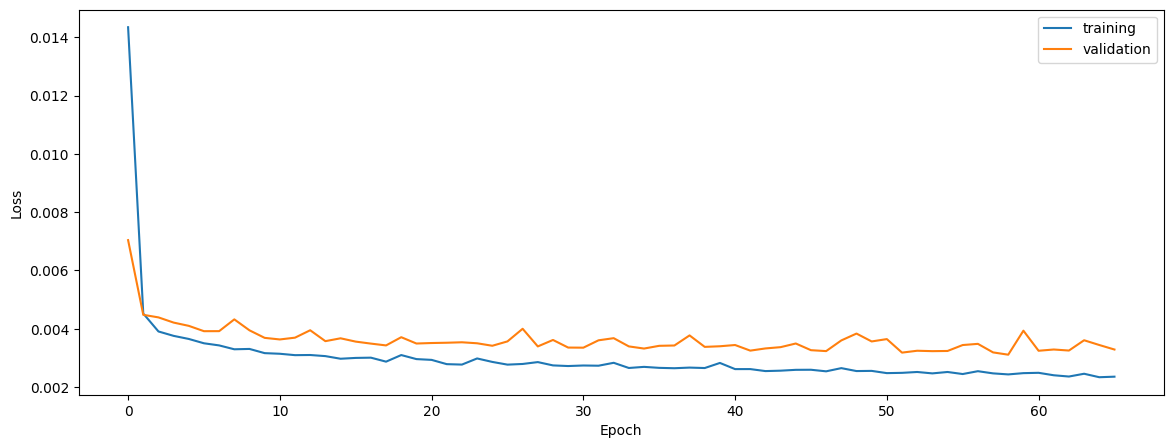

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


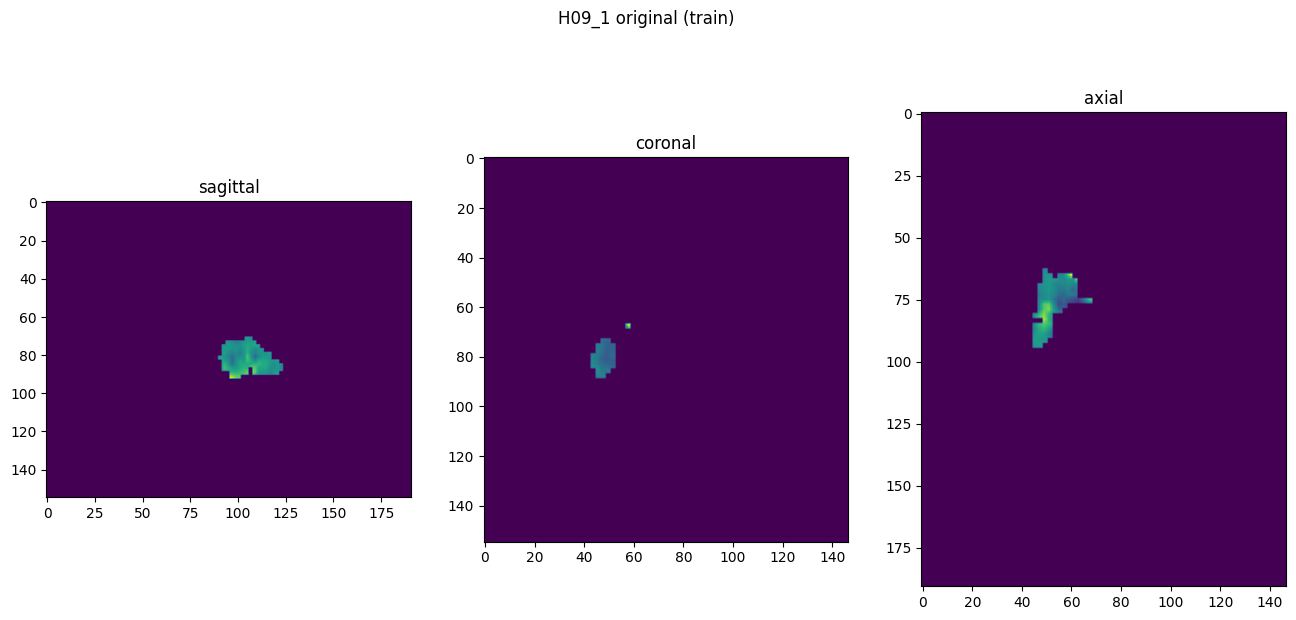

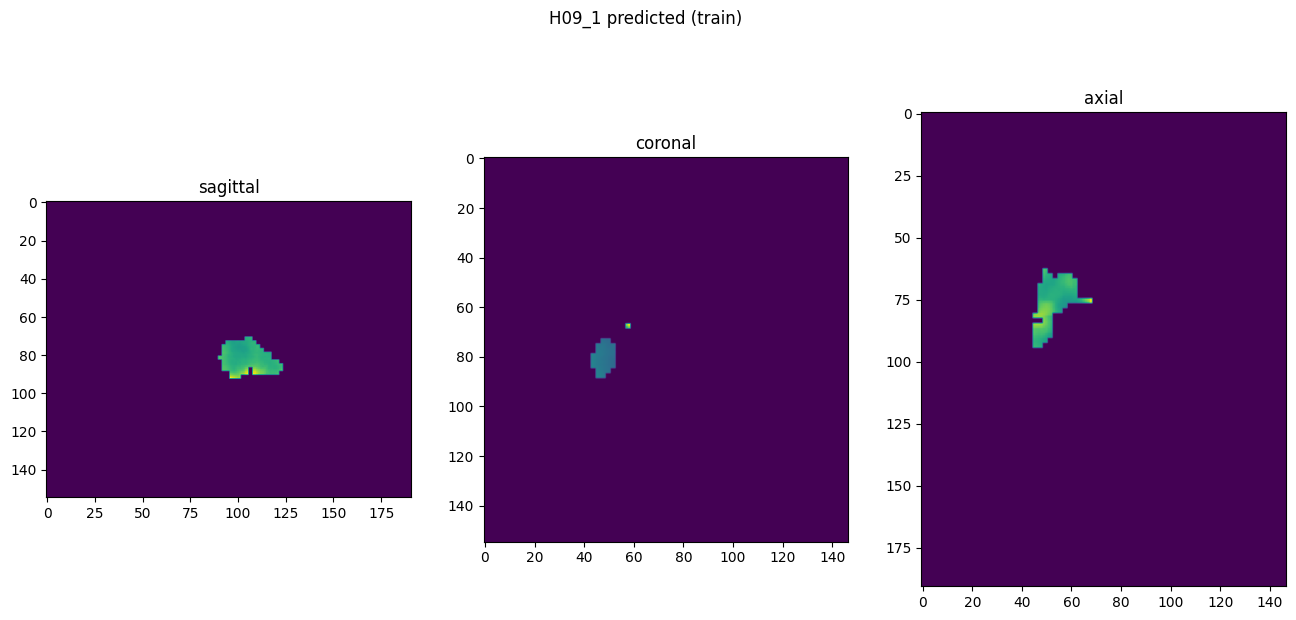

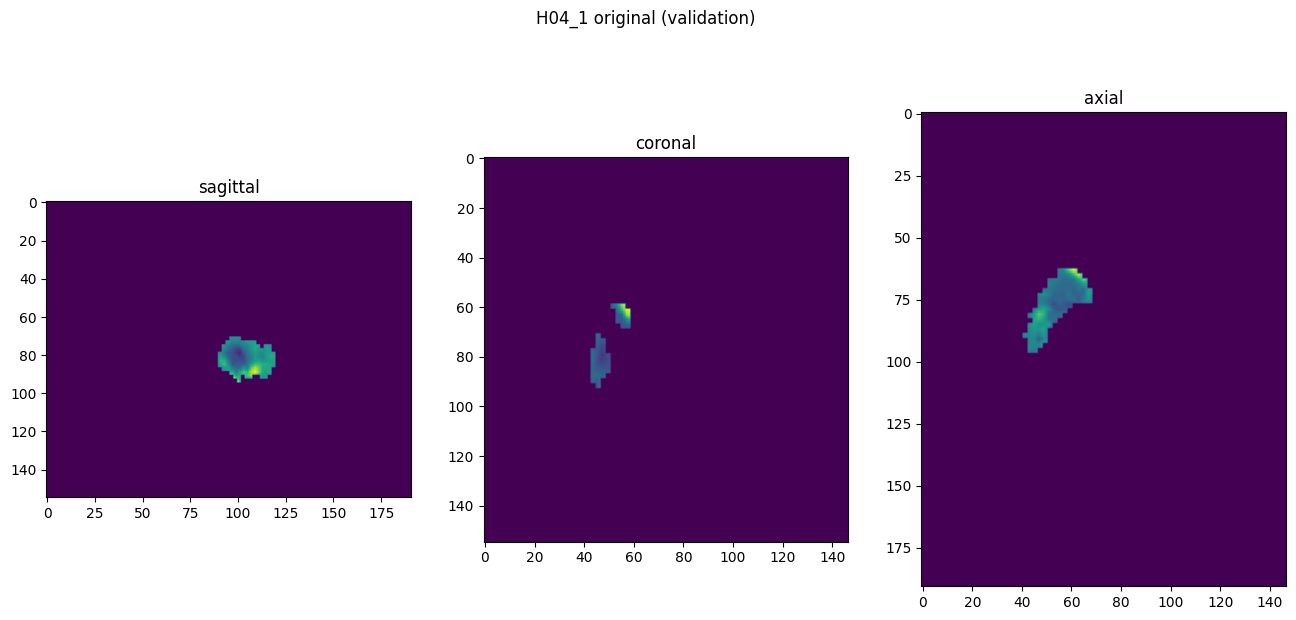

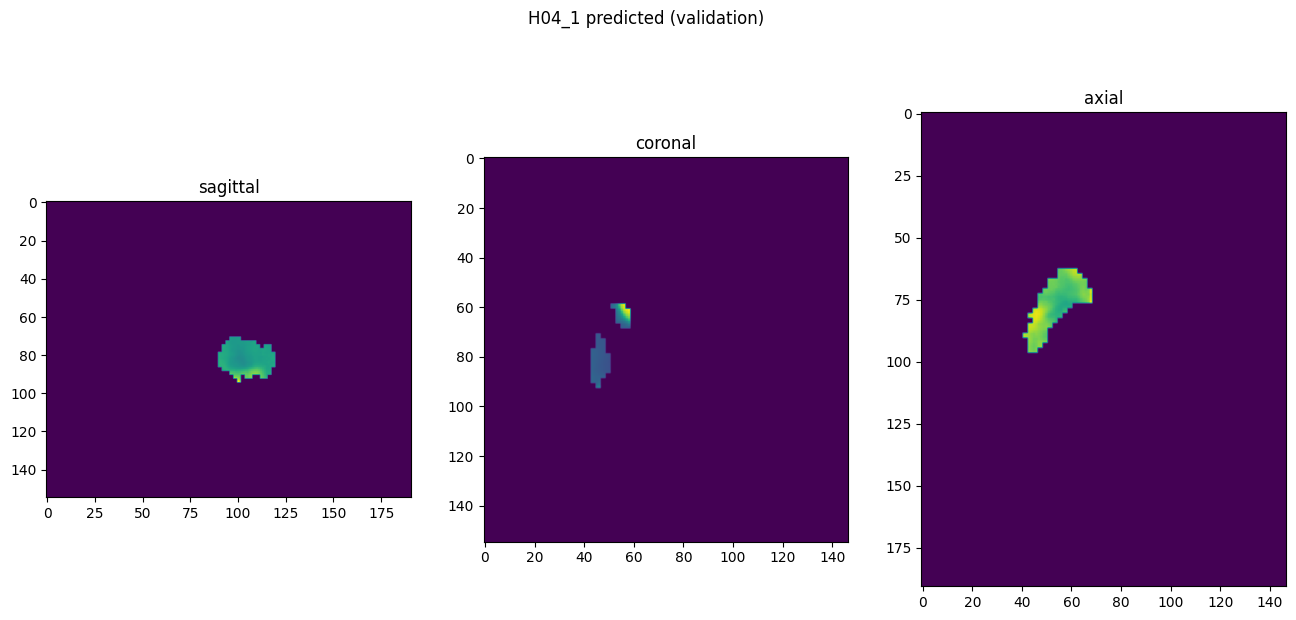

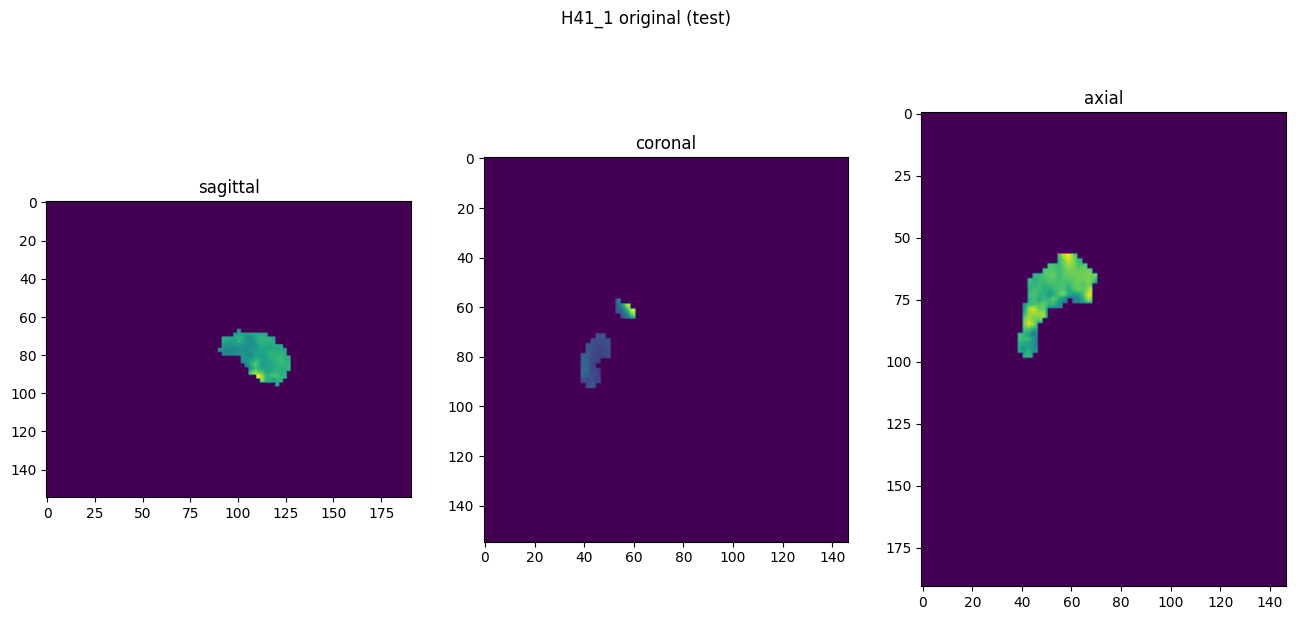

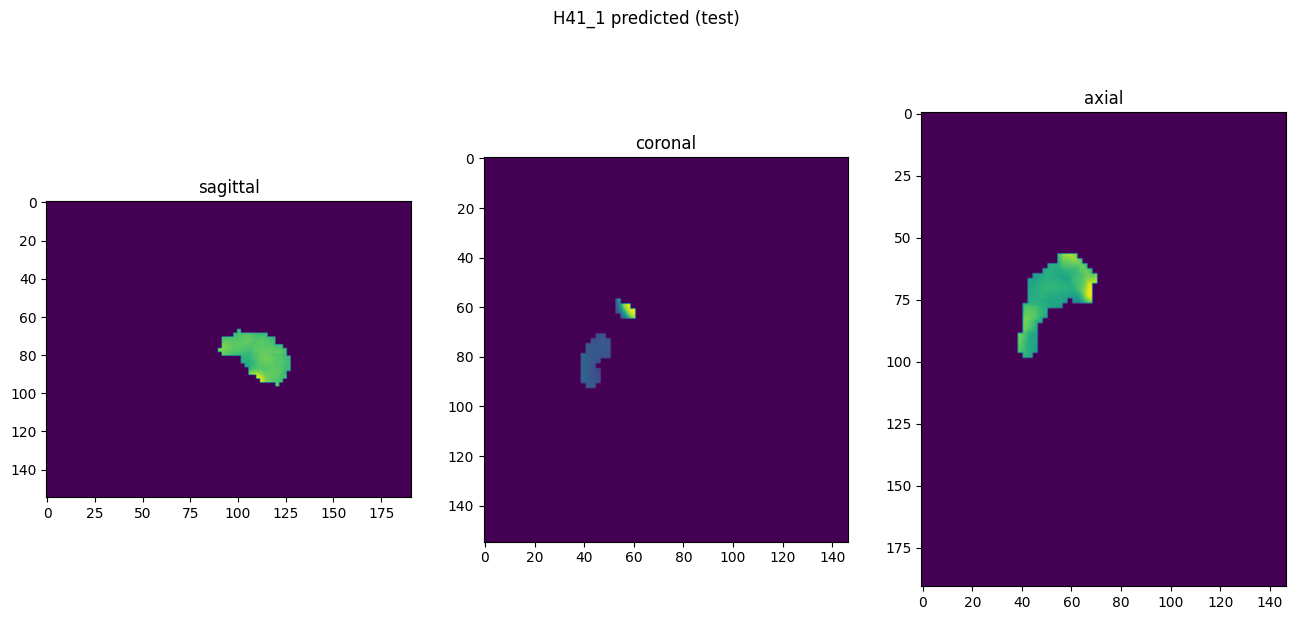

In [10]:
showResults(model, gen, threshold=None, background=False)